# Stations

In [3]:
import mpl_toolkits
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import os
import math

from obspy import read
from scipy import signal
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client
from obspy import read_inventory
from obspy.core.util import (BASEMAP_VERSION, CARTOPY_VERSION,
                             MATPLOTLIB_VERSION, PROJ4_VERSION)

In [ ]:
# Use the station service to access station metadata from GeoNet stations. 
client = FDSN_Client("GEONET")

In [ ]:
# This example gets all stations.
inventory = client.get_stations(starttime = "2016-01-01 00:00:00.000", level="response")

In [ ]:
inventory

In [ ]:
stations_network = inventory[0]
stations_network

In [ ]:
first_station = stations_network[0]
first_station

In [ ]:
# NZ bounding box
min_lat = -47.749
max_lat = -33.779
min_long = 166.104
max_long = 178.990

In [ ]:
# Create a data frame for each station
stations = []
longitudes = []
latitudes = []
sites = []

for station in stations_network:
    stations.append(station.code)
    latitudes.append(station.latitude)
    longitudes.append(station.longitude)
    sites.append(station.site.name)
    
data_map = {'station_code': stations, 'longitude':longitudes, 'latitude':latitudes, 'site':sites}
df = pd.DataFrame(data=data_map)

# use New Zealand bounding box coordinates to get the stations
df = df[(df['longitude'] >= min_long) & (df['longitude'] <= max_long)]
df = df[(df['latitude'] >= min_lat) & (df['latitude'] <= max_lat)]
df.head()

In [ ]:
# number of stations
df.shape

In [ ]:
# plot stations 
df.plot(x="longitude", y="latitude", kind="scatter", figsize=(7,7))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = countries[countries["name"] == "New Zealand"].plot(ax=ax)
ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
del ax

In [ ]:
# plot NZ map with stations
fig, ax = plt.subplots(figsize=(10,10))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

ax = countries[countries["name"] == "New Zealand"].plot(color="lightgrey", ax=ax)
df.plot(x="longitude", y="latitude", kind="scatter", ax=ax)

# add grid
ax.grid(b=True, alpha=0.5)
plt.show()
del ax

In [ ]:
first_station.plot(0.001,output="VEL")

In [ ]:
selected_58_stations = ['BFZ', 'BHW', 'BKZ', 'COVZ', 'CVZ', 'DCZ', 'DSZ', 'EAZ', 'ETVZ', 'FWVZ',
              'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ', 'KHZ', 'KNZ', 'KUZ', 
               'LBZ','LTZ', 'MLZ', 'MQZ', 'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 
               'OPRZ', 'OPZ','OUZ', 'OXZ', 'PUZ', 'PXZ', 'QRZ', 'RATZ', 'RPZ', 'RTZ', 
               'SYZ', 'THZ', 'TLZ','TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ', 'URZ', 'VRZ'
               , 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ', 'WSRZ', 'WVZ']

In [ ]:
df_58 = df.loc[df.station_code.isin(selected_58_stations)]

In [ ]:
df_58.head()

In [ ]:
# plot NZ map with 58 stations
fig, ax = plt.subplots(figsize=(10,10))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

ax = countries[countries["name"] == "New Zealand"].plot(color="lightgrey", ax=ax)
df_58.plot(x="longitude", y="latitude", kind="scatter", ax=ax, color='r')

plt.axis('off')
    
plt.show()
del ax

## Data analysis

In [ ]:
events_df = pd.read_pickle('data/events.pkl')
events_df.head()

In [ ]:
# total earthquakes (123165)
events_df.shape

In [ ]:
# filter out rows that dont have one of the data features
events_df = events_df[events_df.latitude != -1]
events_df = events_df[events_df.longitude != -1]
events_df = events_df[events_df.magnitude != -1]
events_df = events_df[events_df.depth != -1]

In [ ]:
# total earthquakes after filtering (122465)
events_df.shape

In [ ]:
# plot earthquakes on NZ map
fig, ax = plt.subplots(figsize=(10,10))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = countries[countries["name"] == "New Zealand"].plot(color="lightgrey", ax=ax)
events_df.plot(x="longitude", y="latitude", kind="scatter", s=0.1, ax=ax)
plt.show()
del ax

In [ ]:
# plot magnitude
fig, ax = plt.subplots(figsize=(10,10))
w = 0.2
n = np.ceil((events_df['magnitude'].max() - events_df['magnitude'].min())/w)
plt.hist(events_df['magnitude'], histtype='bar', ec='black', bins=int(n))
ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.ylabel('Number of Earthquakes', fontsize=20)
plt.xlabel('Magnitude (M)', fontsize=20);
del fig
del ax

In [ ]:
# plot depth
fig, ax = plt.subplots(figsize=(10,10))
plt.hist(events_df['depth'] / 1000, histtype='bar', ec='black', bins=25)
ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.ylabel('Number of Earthquakes', fontsize=20)
plt.xlabel('Depth (km)', fontsize=20);
del fig
del ax

In [ ]:
# filter magnitude 1-3
events_df = events_df[(events_df.magnitude >= 1) & (events_df.magnitude <= 3)]
#filter depth < 200km (200000m)
events_df = events_df[events_df.depth < 200000]

In [ ]:
# (106623)
events_df.shape

In [ ]:
# save the processed df
events_df.to_pickle('data/events_processed.pkl')

# Seismic Measurements

In [53]:
# normalize data between -1 and 1
def normalize_data(data):
    normalized = []
    xmin=min(data)
    xmax=max(data)
    for x in data:
        res = 2.0 * ((x - xmin) / (xmax - xmin)) - 1.0
        normalized.append(res)
    return normalized

# time -> 0 - 30 secs
def normalize_time(data):
    normalized = []
    xmin=min(data)
    xmax=max(data)
    for x in data:
        normalized.append(((x - xmin)/(xmax - xmin)) * 30)
    return normalized

    
# plot wave straight from mseed file
def plot_wave_mseed(data, times):
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, len(data))]
    for i, (d, t) in enumerate(zip(data, times)):
        # get same amount of values per each station 
        new_time = t[:3001]
        # normalize
        new_time = normalize_time(new_time)
        new_time = np.array(new_time)
        
        # downsample 100Hz to 50Hz
        #new_time = new_time[::4]
        new_data = d[:3001]
        #new_data = np.array(new_data)
        #new_data = np.array(normalize_data(new_data))
        #new_data = new_data[::4]
        ax.plot(new_time, new_data, color=colors[i])
    ax.tick_params(axis='both', labelsize=15)
    ax.tick_params(axis='both', labelsize=15)
    plt.ylabel('HHZ Normalized Velocity', fontsize=20)
    plt.xlabel('Timestep', fontsize=20);
    plt.grid()
    plt.show()
    del fig
    del ax

In [47]:
ex = read('datasets/waveforms/smi:nz.org.geonet/2016p000001/NZ.APZ.10.HHZ__20160101T000026Z__20160101T000056Z.mseed')
ex

1 Trace(s) in Stream:
NZ.APZ.10.HHZ | 2016-01-01T00:00:21.927961Z - 2016-01-01T00:01:00.277961Z | 100.0 Hz, 3836 samples

In [48]:
ex2 = read('datasets/waveforms/smi:nz.org.geonet/2016p000001/NZ.BFZ.10.HHZ__20160101T000026Z__20160101T000056Z.mseed')
ex2

1 Trace(s) in Stream:
NZ.BFZ.10.HHZ | 2016-01-01T00:00:23.508389Z - 2016-01-01T00:00:56.678389Z | 100.0 Hz, 3318 samples

In [49]:
ex3 = read('datasets/waveforms/smi:nz.org.geonet/2016p000001/NZ.CVZ.10.HHZ__20160101T000026Z__20160101T000056Z.mseed')
ex3

1 Trace(s) in Stream:
NZ.CVZ.10.HHZ | 2016-01-01T00:00:23.533139Z - 2016-01-01T00:00:57.673139Z | 100.0 Hz, 3415 samples

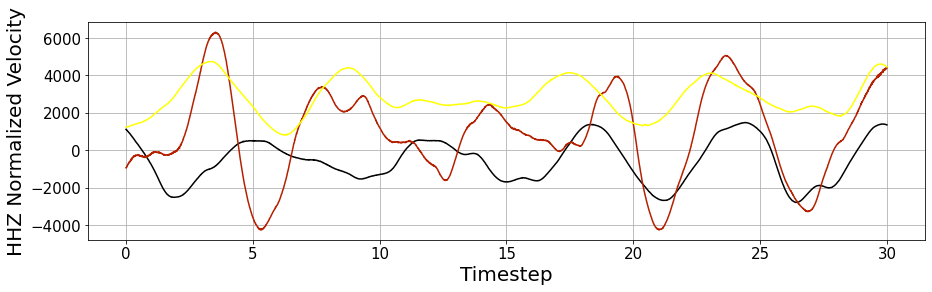

In [65]:
plot_wave_mseed(
                [ex[0].data, ex2[0].data, ex3[0].data], 
                [ex[0].times('matplotlib'), ex2[0].times('matplotlib'), ex3[0].times('matplotlib')]
               )

# Preprocess Seismic Data

In [29]:
time_arr = np.linspace(0.0, 30.0, 3001)
time_arr.shape

(3001,)

In [30]:
# preprocess event seismic data per each station
def preprocess_data(data):
    new_data_arr = []
    for i, d in enumerate(data):
        # get same amount of values per each station 
        new_data = d[:3001]
        
        # normalize
        new_data = np.array(new_data)
        new_data = normalize_data(new_data)
        new_data = np.array(new_data)
            
        # downsample 100Hz to 50Hz
        #new_data = new_data[::4]
        new_data_arr.append(new_data)
        last_appended = new_data
    
    res = np.array(new_data_arr)
    return res

In [31]:
# plot wave normal
def plot_wave_processed(data):
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, len(data))]
    i = 0
    for s in data:
        ax.plot(time_arr, s, color=colors[i])
        i+=1
    ax.tick_params(axis='both', labelsize=15)
    ax.tick_params(axis='both', labelsize=15)
    plt.ylabel('HHZ Velocity', fontsize=20)
    plt.xlabel('Timestep', fontsize=20);
    plt.grid()
    plt.show()
    del fig
    del ax

In [66]:
fun = preprocess_data([ex[0].data, ex2[0].data, ex3[0].data])

In [67]:
fun.shape

(3, 3001)

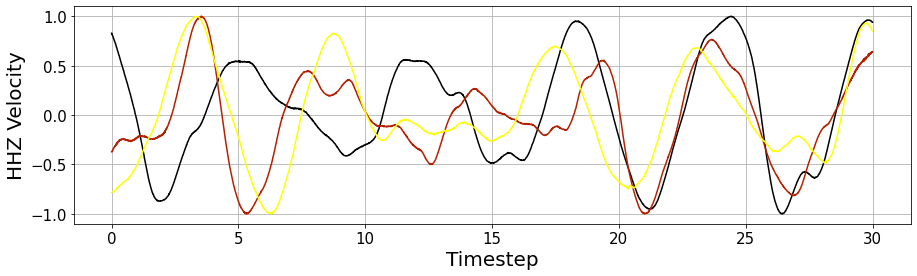

In [68]:
plot_wave_processed(fun)

In [ ]:
os.getcwd()

In [ ]:
os.chdir('../../')
os.getcwd()

In [ ]:
list_of_directories = os.listdir('datasets/normal/waveforms/smi:nz.org.geonet/')
len(list_of_directories)

In [ ]:
os.chdir('datasets/normal/waveforms/smi:nz.org.geonet/')
os.getcwd()

In [ ]:
master_data_per_event = []

In [ ]:
# [0] -> 1st event, [1] -> 2nd event etc.

events_processed = 0
station_count = 0

for directory in list_of_directories:
    
    # open directory of an event
    try: 
        os.chdir(directory)
    except:
        continue
        
    # station files for each event
    station_files = os.listdir()
    
    # station data per event
    station_data_arr = []
    for i in range(0, 64):
        
        # break if we have 58 stations. Move to next event
        if station_count == 58:
            station_count = 0 # reset counter
            break
        
        # cant read a station file, move to next station
        try:
            station_data = read(station_files[i])
        except:
            continue
        
        station_data = station_data[0].data
        
        # if corrupted data, continue to next station
        min_data = min(station_data)
        max_data = max(station_data)
        if min_data == -14822981 or max_data == -14822981:
            continue
        else:
            station_data_arr.append(station_data)
            station_count += 1
    
    if len(station_data_arr) == 58:
        station_data_processed = preprocess_data(station_data_arr)
        master_data_per_event.append(station_data_processed)
    
    
    if events_processed == 12000:
        break
        
    events_processed += 1
    
    if events_processed % 1000 == 0:
        print(events_processed)
    
    del station_data_arr

    os.chdir('../')

In [ ]:
len(master_data_per_event)

In [ ]:
len(master_data_per_event[0][1])

In [ ]:
os.getcwd()

In [ ]:
os.chdir('../')

In [ ]:
os.chdir('100hz')

In [ ]:
os.getcwd()

In [ ]:
pickle.dump(master_data_per_event, open("normal_seismic_100hz.pkl", "wb"))

In [ ]:
os.getcwd()

In [ ]:
os.chdir('..')

In [ ]:
plot_wave_processed(master_data_per_event[52])

In [ ]:
# READING EARTHQUAKE BEHAVIOUR
pkl_file = open('datasets/5hz/x_test.pkl', 'rb')
earthquakes_data = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
earthquakes_data.shape

In [ ]:
# READING NORMAL BEHAVIOUR
pkl_file = open('data/normal_seismic_2hz.pkl', 'rb')
normal_data = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
normal_data[0].shape

In [ ]:
plot_wave_processed(normal_data[0])

'/Users/irtazahashmi/Desktop/RP'